In [ ]:
pip install transformers datasets evaluate torch accelerate scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00


In [3]:
import zipfile
import os

zip_path = "/content/TASK1DATASET.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/emotion_data")

print("Files extracted:")
os.listdir("/content/emotion_data")


Files extracted:


['emotion_labels.csv', 'emotions-dataset.csv']

In [4]:
import pandas as pd

df_main = pd.read_csv("/content/emotion_data/emotions-dataset.csv")
df_labels = pd.read_csv("/content/emotion_data/emotion_labels.csv")

print("Main dataset columns:", df_main.columns)
print("Labels dataset columns:", df_labels.columns)

df_main.head()
df_labels.head()


Main dataset columns: Index(['content', 'sentiment'], dtype='object')
Labels dataset columns: Index(['label', 'emotion'], dtype='object')


,label,emotion
0,0,Joy
1,1,Sadness
2,2,Neutral
3,3,Anger


In [5]:
import pandas as pd

df = pd.read_csv('/content/emotion_data/emotions-dataset.csv')
labels = pd.read_csv('/content/emotion_data/emotion_labels.csv')

print("Main dataset columns:", df.columns)
print("Labels dataset columns:", labels.columns)
df.head()


Main dataset columns: Index(['content', 'sentiment'], dtype='object')
Labels dataset columns: Index(['label', 'emotion'], dtype='object')


,content,sentiment
0,not a very good day at the house,1
1,tommcfly i saw you on tues and last niiiighht ...,2
2,i dont even understand the intro to this book,3
3,happy mothers day mommy and grandma haha ily,0
4,quotoh i got so fucked up last nightquot but u...,3


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = df.merge(labels, left_on='sentiment', right_on='label', how='left')
df = df[['content', 'emotion']]
df.dropna(inplace=True)


emotion2id = {e: i for i, e in enumerate(df['emotion'].unique())}
id2emotion = {i: e for e, i in emotion2id.items()}
df['label'] = df['emotion'].map(emotion2id)

print("Emotion to ID mapping:", emotion2id)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['content'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

len(train_texts), len(test_texts)


Emotion to ID mapping: {'Sadness': 0, 'Neutral': 1, 'Anger': 2, 'Joy': 3}


(17640, 4410)

In [7]:
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

max_length = 128

class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = EmotionDataset(train_texts, train_labels, tokenizer, max_length)
test_dataset = EmotionDataset(test_texts, test_labels, tokenizer, max_length)

train_dataset[0]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

{'input_ids': tensor([  101,  2026,  2684,  2081,  2033,  2514, 11654,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [9]:
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report
import torch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

num_labels = len(emotion2id)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
model = model.to(device)

epochs = 5
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


model.train()
for epoch in range(epochs):
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for batch in loop:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader)}")


Using device: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/5: 100%|██████████| 1103/1103 [06:12<00:00,  2.96it/s, loss=1.07]


Epoch 1 Loss: 0.9156915341737805


Epoch 2/5: 100%|██████████| 1103/1103 [06:10<00:00,  2.98it/s, loss=0.49]


Epoch 2 Loss: 0.6882215870150845


Epoch 3/5: 100%|██████████| 1103/1103 [06:10<00:00,  2.98it/s, loss=0.159]


Epoch 3 Loss: 0.471011955544339


Epoch 4/5: 100%|██████████| 1103/1103 [06:10<00:00,  2.98it/s, loss=0.0839]


Epoch 4 Loss: 0.29183239297618785


Epoch 5/5: 100%|██████████| 1103/1103 [06:10<00:00,  2.98it/s, loss=0.198]

Epoch 5 Loss: 0.19534102613097926


Accuracy: 0.6414965986394557
Macro F1-score: 0.6427998225244114

Classification Report:
              precision    recall  f1-score   support

     Sadness       0.55      0.59      0.57      1033
     Neutral       0.71      0.70      0.71      1042
       Anger       0.79      0.73      0.76      1170
         Joy       0.53      0.53      0.53      1165

    accuracy                           0.64      4410
   macro avg       0.64      0.64      0.64      4410
weighted avg       0.65      0.64      0.64      4410



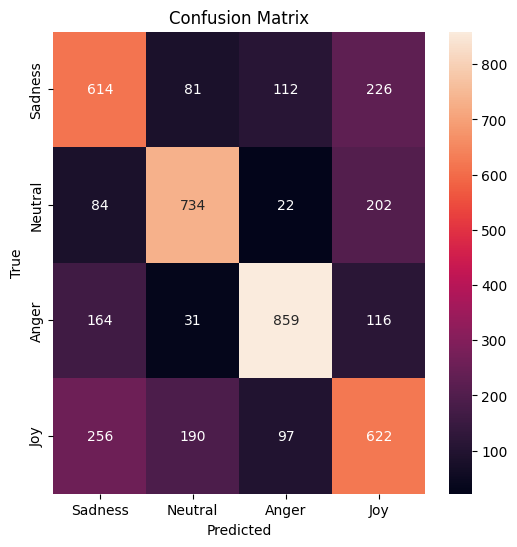

In [10]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()

preds = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)
        preds.extend(predictions.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

acc = accuracy_score(true_labels, preds)
f1 = f1_score(true_labels, preds, average='macro')

print("Accuracy:", acc)
print("Macro F1-score:", f1)
print("\nClassification Report:")
print(classification_report(true_labels, preds, target_names=list(emotion2id.keys())))


cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion2id.keys(), yticklabels=emotion2id.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [11]:
def predict_emotion(text):
    model.eval()

    encoding = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding='max_length',
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**encoding)
        pred = torch.argmax(outputs.logits, dim=1).item()

    return id2emotion[pred]

test_samples = [
    "I am extremely happy today!",
    "Why does everything make me sad",
    "I am very angry right now",
    "It's just a normal day"
]

for s in test_samples:
    print(s,"=>", predict_emotion(s))


I am extremely happy today! => Neutral
Why does everything make me sad => Sadness
I am very angry right now => Anger
It's just a normal day => Sadness


In [12]:
model.save_pretrained("emotion_bert_model")
tokenizer.save_pretrained("emotion_bert_model")


('emotion_bert_model/tokenizer_config.json',
 'emotion_bert_model/special_tokens_map.json',
 'emotion_bert_model/vocab.txt',
 'emotion_bert_model/added_tokens.json')

In [13]:
def predict_emotion(text):
    model.eval()

    encoding = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding='max_length',
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**encoding)
        pred = torch.argmax(outputs.logits, dim=1).item()

    return id2emotion[pred]

test_samples = [
    "I am extremely happy today!",
    "Why does everything make me sad",
    "I am very angry right now",
    "It's just a normal day"
]

for s in test_samples:
    print(s,"=>", predict_emotion(s))

test_samples = [
    "I am extremely happy today!",
    "I am happiest today",
    "its fine",
    "lovely "]
for s in test_samples:
    print(s,"=>", predict_emotion(s))


I am extremely happy today! => Neutral
Why does everything make me sad => Sadness
I am very angry right now => Anger
It's just a normal day => Sadness
I am extremely happy today! => Neutral
I am happiest today => Neutral
its fine => Neutral
lovely  => Joy
